In [1]:
%%capture
try:
    from tinygp import kernels, GaussianProcess
except ModuleNotFoundError:
    %pip install -qq tinygp
    from tinygp import kernels, GaussianProcess

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp

try:
    import jaxopt
except ModuleNotFoundError:
    %pip install jaxopt
    import jaxopt

tfd = tfp.distributions

from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [2]:
# import os

# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [3]:
pml.latexify(width_scale_factor=2, fig_height=1.7)
plt.rcParams["lines.markersize"] = 3 if pml.is_latexify_enabled() else 6

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Data

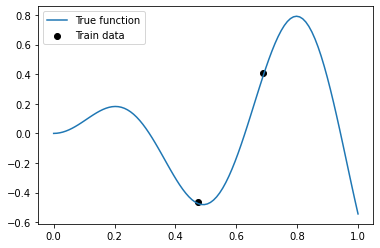

In [4]:
seed = jax.random.PRNGKey(2)
true_f = lambda x: jnp.sin(10 * x) * x
x = jnp.linspace(0, 1, 100)
noise_std = 0.05
y = true_f(x) + jax.random.normal(seed, shape=x.shape) * noise_std

x_train, x_pool, y_train, y_pool = train_test_split(x, y, train_size=2, random_state=7)

plt.plot(x, true_f(x), label="True function")
plt.scatter(x_train, y_train, color="k", label="Train data")
plt.legend();

## Common functions

In [5]:
def build_model(params, x):
    log_variance, log_scale = params
    variance, scale = jnp.exp(log_variance), jnp.exp(log_scale)
    return GaussianProcess(variance * kernels.ExpSquared(scale=scale), x)


def loss_fn(params, x, y):
    model = build_model(params, x)
    return -model.log_probability(y)


def fit(params, x, y):
    solution = solver.run(params, x=x, y=y)
    return solution.params


def predict(params, x, y, x_pool):
    model = build_model(params, x)
    pred_model = model.condition(y, x_pool, diag=noise_std**2).gp
    return pred_model.loc, pred_model.variance


def variance_fn(params, x_train, y_train, x_pool):
    _, variance = predict(params, x_train, y_train, x_pool)
    return variance


def prob_of_improvement_fn(params, x_train, y_train, x_pool):
    loc, _ = predict(params, x_train, y_train, x_train)
    best_loc = jnp.max(loc)

    loc, variance = predict(params, x_train, y_train, x_pool)
    prob_of_improvement = jax.scipy.stats.norm.cdf((loc - best_loc) / (variance**0.5))
    return prob_of_improvement

In [6]:
solver = jaxopt.ScipyMinimize(fun=loss_fn)
log_scale = jnp.log(1.0)
log_variance = jnp.log(1.0)
initial_params = (log_variance, log_scale)
n_iterations = 6

In [7]:
def plot_function(
    initial_x_train,
    initial_y_train,
    x_train,
    y_train,
    x_test,
    y_pred,
    y_var,
    acquisition_fn_values,
    acquisition_fn_name,
    legend,
):
    fig, ax = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[2, 1]))

    lower, upper = y_pred - 2 * (y_var**0.5), y_pred + 2 * (y_var**0.5)
    ax[0].fill_between(x_test, lower, upper, alpha=0.4)
    ax[0].scatter(initial_x_train, initial_y_train, color="k", zorder=10)
    ax[0].scatter(x_train, y_train, color="r", zorder=5)
    ax[0].plot(x, true_f(x), label="True function")
    ax[0].plot(x_test, y_pred, color="g", linestyle="--", label="Predictive mean")
    if legend:
        ax[0].legend(frameon=False, loc="lower left", fontsize=8)
    else:
        ax[0].legend([r"95\% confidence"], loc="lower right")

    ax[0].set_ylim(-1.5, 1.1)

    ax[1].plot(x, acquisition_fn_values, label=acquisition_fn_name)
    ax[1].legend(frameon=False)
    name = "_".join(acquisition_fn_name.lower().split())
    pml.savefig(f"active_learning_vs_bo_{name}_iteration{n_iterations}")


def run_optimization_and_plot(
    acquisition_fn, acquisition_fn_name, x_train, y_train, x_pool, y_pool, n_iterations, legend=True
):
    initial_x_train, initial_y_train = x_train, y_train
    for _ in range(n_iterations):
        best_params = fit(initial_params, x_train, y_train)
        acquisition = acquisition_fn(best_params, x_train, y_train, x_pool)
        best_idx = jnp.argmax(acquisition)
        x_train = jnp.append(x_train, x_pool[best_idx])
        y_train = jnp.append(y_train, y_pool[best_idx])
        x_pool, y_pool = jax.tree_map(lambda x: jnp.delete(x, best_idx), (x_pool, y_pool))
        print("Number of train points", len(x_train))

    y_pred, y_var = predict(best_params, x_train, y_train, x)
    acquisition = acquisition_fn(best_params, x_train, y_train, x)
    plot_function(
        initial_x_train, initial_y_train, x_train, y_train, x, y_pred, y_var, acquisition, acquisition_fn_name, legend
    );

## Active learning

Number of train points 3
Number of train points 4
Number of train points 5
Number of train points 6
Number of train points 7
Number of train points 8


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


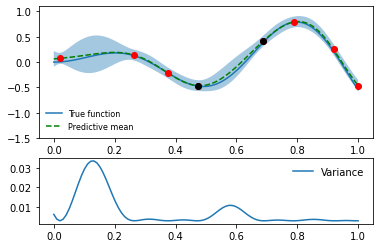

In [8]:
run_optimization_and_plot(variance_fn, "Variance", x_train, y_train, x_pool, y_pool, n_iterations=n_iterations)

## Bayesian Optimization

Number of train points 3
Number of train points 4
Number of train points 5
Number of train points 6
Number of train points 7
Number of train points 8


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


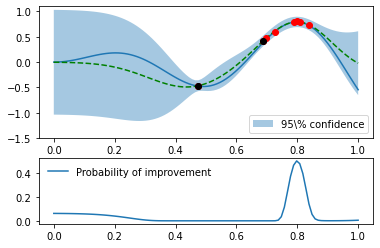

In [9]:
run_optimization_and_plot(
    prob_of_improvement_fn,
    "Probability of improvement",
    x_train,
    y_train,
    x_pool,
    y_pool,
    n_iterations=n_iterations,
    legend=False,
)